In [10]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import dereference
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import scipy

###
#FSD Tile Pixel pitch
pixel_pitch = 0.37200
###

###
# mapping (io_group, io_channel, chip_id, channel_id) <--> unique identifier
def unique_to_channel_id(unique):
    return (unique % 100)

def unique_to_chip_id(unique):
    return ((unique// 100) % 1000)

def unique_to_io_channel(unique):
    return ((unique//(100*1000)) % 1000)

def unique_to_io_group(unique):
    return ((unique // (100*1000*1000)) % 1000)

def unique_chip_id(d):
    return ((d['io_group'].astype(int)*1000+d['io_channel'].astype(int))*1000 \
            + d['chip_id'].astype(int))*100

def unique_channel_id(d):
    return ((d['io_group'].astype(int)*1000+d['io_channel'].astype(int))*1000 \
            + d['chip_id'].astype(int))*100 + d['channel_id'].astype(int)
###

###
# Data format definition and some useful hdf5 wrapper functions

import gc

# 
# Every track that projects onto a pixel will have 1 entry PER PIXEL CROSSED in the format below
# - Each list will always have the same length, and an entry at index j is associated with a unique track+pixel
data_store_nominal = {

        # pixel id crossed by a track section (defined below)
        'pixel_id' : [], 
        # pixel y position crossed by a track section
        'pixel_y' : [],
        # pixel z position crossed by a track section
        'pixel_z' : [],
        # angle of track crossing pixel in x,z plane
        'angle'    : [],
        # (1,2) for which drift region the track was in
        'anode' : [],
        # total length of the track crossing 
        'total_length' : [],
        # length of the track crossing this particular pixel
        'pixel_length' : [],
        # bool - found a hit consistent with this track crossing 
        'is_hit' : [],
        # drift time of hit if found, else -1
        'hit_drift' : [],
        # io_group of hit if found, else -1
        'hit_io_group' : [],
        # io_chan of hit if found, else -1
        'hit_io_chan' : [],
        # chip_id of hit if found, else -1
        'hit_chip_id' : [],
        # chan_id of hit if found, else -1
        'hit_chan_id' : [],
        # charge sum of all hits on this channel associated with this track
        'total_charge_collected' : []
        }
#

def close_all_h5_files():
    for obj in gc.get_objects():   # Browse through ALL objects
        if isinstance(obj, h5py.File):   # Just HDF5 files
            try:
                obj.close()
            except:
                pass # Was already closed

def create_h5_file_safe(file_name, data_format=data_store_nominal.keys()):
    '''Create an HDF5 file, don't overwrite if the file already exists'''
    if os.path.isfile(file_name):
        print('Not creating file, already exists!')
        return

    with h5py.File(file_name, "w") as f:
        for key in data_format:
            f.create_dataset(key, data=np.array([]), compression="gzip", maxshape=(None,))

    return

###

In [3]:
nominal_dir = '/global/cfs/cdirs/dune/www/data/FSD/reflows/v2/flow/cosmics/08Nov2024/'
nominal_files = sorted(os.listdir(nominal_dir))

In [5]:
###
# Small geometry hack... get all possible pixel y,z values from a data file
f=h5py.File(nominal_dir+nominal_files[0])
f['charge/events/data'].dtype
hy = f['charge/calib_prompt_hits/data']['y']
hz = f['charge/calib_prompt_hits/data']['z']

pix_y = np.sort(np.unique(hy))
pix_z = np.sort(np.unique(hz))

min_y = np.min(pix_y)
min_z = np.min(pix_z)

f.close()
###

In [6]:
###
# Some useful geometry helper functions
# Note pix_ij, 'pixel_id' is NOT equivalent to unique_channel_id above

def get_pixel_yz(i,j):
    '''Return (y,z) of pixel at index (i,j)'''
    return pix_y[i], pix_z[j]

def get_closest_pix_ij(y, z):
    '''Return i,j index of closest pixel to position (y,z)'''
    closest_y = np.argmin( np.absolute(pix_y - y) )
    closest_z = np.argmin( np.absolute(pix_z - z) )
    return closest_y, closest_z

def get_unique_pixel_id(i, j):
    '''Return unique single integer encoding i,j indices'''
    return i*100000 + j

def get_unique_pixel_ids(ii):
    '''Array version of get_unique_pixel_id'''
    return ii[:,0]*1000000 + ii[:,1]

def get_unique_pixel_ids_yz( yz ):
    '''Return unique single integer encoding i,j indices from yz positions. yz is an array here.'''
    i = np.rint((yz[:,0]-min_y)/pixel_pitch).astype(int)
    j = np.rint((yz[:,1]-min_z)/pixel_pitch).astype(int)
    return i*1000000 + j
    
def get_ij_from_id(id_val):
    '''inverse for id-->(i,j)'''
    return id_val//1000000 , id_val % 1000000

def get_closest_pixel_yz(y, z):
    '''Get pixel center position closest to point (y,z)'''
    i, j = get_closest_pix_ij(y, z)
    return get_pixel_yz(i, j)

def get_all_hit_pixels(start, finish):
    '''Get an array of all pixel (y,z) positions crossed by a track passing from pt. start-->finish.

        Returns <pixel yz position array>, <length of track crossing pixel (projected in 2D)>

        Crossing length is done by histogramming discrete points so crossing lengths < pixel_pitch/10 might be missed.
    '''
    direction = finish - start    
    length = np.linalg.norm(direction)
    direction = direction/length
    
    n_pts_to_test = int( (length / pixel_pitch) * 10)+1
    line_pts = np.linspace(0, length, n_pts_to_test)
    
     # get pixels which are hit
    hit_y_z = np.zeros( ( n_pts_to_test, 2 )  )
    for i in range(n_pts_to_test):
        y, z = start[0] + line_pts[i]*direction[0], start[1] + line_pts[i]*direction[1] 
        _y, _z = get_closest_pixel_yz(y, z)
        
        hit_y_z[i,0] =  _y
        hit_y_z[i,1] =  _z

    pyz, counts = np.unique(hit_y_z, axis=0, return_counts=True)
    mask = (pyz[:,0] > np.min(pix_y)) & (pyz[:,0] < np.max(pix_y)) & (pyz[:,1] > np.min(pix_z)) & (pyz[:,1] < np.max(pix_z))

    pyz=pyz[mask]
    counts = counts[mask]

    return pyz, length*(counts / np.sum(counts))
###
    

In [6]:
%matplotlib ipympl

In [7]:
###
# Some test functions to draw fake lines, check crossing pixel calculations

def plot_anode_and_pixels():
    fig = plt.figure(figsize=(20, 32))
    ax = fig.add_subplot()

    for y in pix_y:
        ax.axhline(y-pixel_pitch/2, color='grey', linewidth=0.01)
        ax.axhline(y+pixel_pitch/2, color='grey', linewidth=0.01)

    for z in pix_z:
        ax.axvline(z-pixel_pitch/2, color='grey', linewidth=0.01)
        ax.axvline(z+pixel_pitch/2, color='grey', linewidth=0.01)

    ax.set_ylim( np.min(pix_y), np.max(pix_y)  )
    ax.set_xlim( np.min(pix_z), np.max(pix_z)  )
    ax.set_aspect('equal')

    #draw a line

    plt_x = np.linspace(-20, 20, 2000)

    yy =  pixel_pitch/np.pi/5 + np.sqrt(2*np.pi/3)*plt_x
    zz =  pixel_pitch/np.pi/3 + np.sqrt(np.pi)*plt_x*1.555

    start, finish = np.array([np.min(yy), np.min(zz)]), np.array([np.max(yy), np.max(zz)] )

    ax.plot(zz, yy, color='red', linewidth=0.2)

    pyz, lengths = get_all_hit_pixels(start, finish)

    sc = ax.scatter( pyz[:,1], pyz[:,0], c=lengths, marker='s', s=0.5 )
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('length over pixel [cm]', rotation=270, fontsize=16)

    ax.set_xlabel( 'z [cm]', fontsize=16 )
    ax.set_ylabel( 'y [cm]', fontsize=16 )

def plot_anode_and_pixels_with_hits(pyz, lengths):
    fig = plt.figure(figsize=(20, 32))
    ax = fig.add_subplot()

    for y in pix_y:
        ax.axhline(y-pixel_pitch/2, color='grey', linewidth=0.01)
        ax.axhline(y+pixel_pitch/2, color='grey', linewidth=0.01)

    for z in pix_z:
        ax.axvline(z-pixel_pitch/2, color='grey', linewidth=0.01)
        ax.axvline(z+pixel_pitch/2, color='grey', linewidth=0.01)

    ax.set_ylim( np.min(pix_y), np.max(pix_y)  )
    ax.set_xlim( np.min(pix_z), np.max(pix_z)  )
    ax.set_aspect('equal')

    #draw a line
    
    sc = ax.scatter( pyz[:,1], pyz[:,0], c=lengths, marker='s', s=0.5, vmin=pixel_pitch/2, vmax=pixel_pitch*np.sqrt(2) )
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('length over pixel [cm]', rotation=270, fontsize=16)

    ax.set_xlabel( 'z [cm]', fontsize=16 )
    ax.set_ylabel( 'y [cm]', fontsize=16 )
    return ax
###
         

In [8]:
def fit_line_3d(points):
    """
    Fits a straight line to an array of 3D points using PCA.
    
    Parameters:
        points (np.ndarray): An Nx3 array of 3D points.

    Returns:
        point_on_line (np.ndarray): A point on the best-fit line (the centroid).
        direction (np.ndarray): A unit direction vector of the best-fit line.
    """
    # Ensure input is a numpy array
    points = np.asarray(points)

    # Compute the centroid (a point on the best-fit line)
    centroid = points.mean(axis=0)

    # Subtract the centroid to center the data
    centered_points = points - centroid

    # Compute the covariance matrix of centered points
    cov_matrix = np.cov(centered_points, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Get the eigenvector with the largest eigenvalue (direction of max variance)
    direction = eigenvectors[:, np.argmax(eigenvalues)]

    return centroid, direction

def find_tracks(file, display=False, min_event_nhit=200):

    # initialize data dictionary
    data_store = {}
    for key in data_store_nominal.keys(): data_store[key] = []

    # open file data/references
    f = h5py.File(file)
    hits = f['charge/calib_prompt_hits/data']
    events = f['charge/events/data']['id'][ f['charge/events/data']['nhit']>min_event_nhit]
    events_hits_ref = f['charge/events/ref/charge/calib_prompt_hits/ref'][:]
    events_hits_rref = f['charge/events/ref/charge/calib_prompt_hits/ref_region'][:]
    hit_data = f['charge/calib_prompt_hits/data'][:]
    #
    
    #loop over all relevant events    
    for ev in tqdm(events, smoothing=0.1):
        hits = dereference.dereference(ev, events_hits_ref, hit_data, region=events_hits_rref).flatten()
        
        for anode in [1,2]:
            mog = (hits['io_group']+1)//2 == anode
            if np.sum(mog)<20: continue
    
            _X = np.array([hits['x'][mog], hits['y'][mog], hits['z'][mog]]).transpose()
            _Q = np.array(hits['Q'][mog])
            all_hit_io_group = np.array(hits['io_group'][:][mog])
            all_hit_io_chan = np.array(hits['io_channel'][:][mog])
            all_hit_chip_id = np.array(hits['chip_id'][:][mog])
            all_hit_chan_id = np.array(hits['channel_id'][:][mog])

            pca=PCA(n_components=3)
            pca.fit(_X)
            
            if np.max(pca.explained_variance_ratio_) < 0.98: continue

            #fit all hits to a line
            fcentr, fdirection = fit_line_3d(_X)

            #make sure all sub-sections of the track also fit along this line
            subdir, subcent = [], []
            costhet=[]
            clust_label=[]
            #pca_fit = []
            skip=False
            
            clustering = DBSCAN(eps=20*pixel_pitch, min_samples=2).fit(_X)
            
            for clust in set(clustering.labels_):
                if clust < 0: continue
                m=np.array(clustering.labels_==clust)
                if np.sum(m)<10:continue
                X = _X[m]
                Q = _Q[m]

                hit_io_group=all_hit_io_group[m]
                hit_io_chan=all_hit_io_chan[m]
                hit_chip_id=all_hit_chip_id[m]
                hit_chan_id=all_hit_chan_id[m]

                #do PCA
                pca=PCA(n_components=3)
                pca.fit(X)
                if np.max(pca.explained_variance_ratio_) < 0.98: 
                    continue
                    
                # fit subcluster to a line
                c, ssubdir = fit_line_3d(X)

                #get angular variance between section and original fit
                cos_theta = np.dot(ssubdir, fdirection) / np.linalg.norm(ssubdir) / np.linalg.norm(fdirection)

                if np.absolute(cos_theta) < 0.98: 
                    continue

                # squared distance of all points from line
                # get distance from each point to center
                dist_from_cent = X - c
                norm = np.sqrt(np.sum( dist_from_cent**2, axis=1 ))

                #project onto direction of track
                projection_on_direction = dist_from_cent[:,0]*ssubdir[0] \
                                        + dist_from_cent[:,1]*ssubdir[1] \
                                        + dist_from_cent[:,2]*ssubdir[2]

                perp_component = dist_from_cent - np.array([ projection_on_direction * ssubdir[0], projection_on_direction * ssubdir[1], projection_on_direction * ssubdir[2] ]  ).transpose()
                distance_perp = np.sqrt(np.sum(perp_component**2, axis=1))

                if scipy.stats.trim_mean( distance_perp, 0.05 ) > pixel_pitch/2: continue

                filt_mask = distance_perp < pixel_pitch*np.sqrt(2)
                X_filt = X[filt_mask]
                Q_filt = Q[filt_mask]
                hit_io_group_filt = hit_io_group[filt_mask]
                hit_io_chan_filt =  hit_io_chan[filt_mask]
                hit_chip_id_filt = hit_chip_id[filt_mask]
                hit_chan_id_filt = hit_chan_id[filt_mask]

                #re-do the fit without the stragglers!
                centr, direction = fit_line_3d(X_filt)

                #get track angle to drift direction
                angle = np.arccos( np.absolute(direction[0]) / np.linalg.norm(direction))

                # get predicted pixels which should have hits
                norm = np.sqrt(direction[1]**2 + direction[2]**2)
                #get distance along track from center ignoring drift direction
                projection_on_direction = dist_from_cent[:,1]*direction[1]/norm \
                                    + dist_from_cent[:,2]*direction[2]/norm \

                length = np.max(projection_on_direction) - np.min(projection_on_direction) 

                if length < 8*pixel_pitch: continue

                # now, get all hit pixels in forward direction
                start=centr[1:] - direction[1:]/norm * length/2
                end = centr[1:] + direction[1:]/norm * length/2

                try:
                    pyz, l = get_all_hit_pixels( start, end)
                except:
                    continue

                # find which pixels were MISSED
                all_hit_pixel_ids = get_unique_pixel_ids_yz( X_filt[:,1:] )
                hit_pixel_ids, hit_idx, hit_counts = np.unique(all_hit_pixel_ids, return_index=True, return_counts=True )
            
                predicted_pixel_ids = get_unique_pixel_ids_yz(  pyz  )
                #Now, save summary information, as well as pixel-by-pixel information

                data_store['angle']+=[angle]*l.shape[0]
                data_store['pixel_id'] += list(get_unique_pixel_ids_yz( pyz ))
                data_store['pixel_y'] += list( pyz[:,0] )
                data_store['pixel_z'] += list( pyz[:,1] )
                data_store['pixel_length'] += list(l)
                data_store['anode'] += [anode]*l.shape[0]

                N=len(get_unique_pixel_ids_yz( pyz ))

                _total_charge_collected = [-1]*N
                _hit_drift = [-1]*N
                _is_hit = [False]*N
                _hit_io_group = [-1]*N
                _hit_io_chan = [-1]*N
                _hit_chip_id = [-1]*N
                _hit_chan_id = [-1]*N
                
                for ipid, pid in enumerate(list( get_unique_pixel_ids_yz( pyz ) )):
                    if pid in hit_pixel_ids:
                        indxs = np.where(all_hit_pixel_ids==pid)[0]
                        _total_charge_collected[ipid] =  np.sum(Q_filt[indxs]) 
                        _hit_drift[ipid] = np.mean(X_filt[:,0][indxs]) 
                        _is_hit[ipid] = True
                        _hit_io_group[ipid] = hit_io_group_filt[indxs[0]] 
                        _hit_io_chan[ipid] = hit_io_chan_filt[indxs[0]]
                        _hit_chip_id[ipid] = hit_chip_id_filt[indxs[0]]
                        _hit_chan_id[ipid] = hit_chan_id_filt[indxs[0]]

                data_store['total_charge_collected'] += _total_charge_collected
                data_store['hit_drift'] += _hit_drift
                data_store['is_hit'] += _is_hit
                data_store['hit_io_group'] += _hit_io_group
                data_store['hit_io_chan'] += _hit_io_chan
                data_store['hit_chip_id'] += _hit_chip_id
                data_store['hit_chan_id'] += _hit_chan_id
                 
                if not len(data_store['pixel_id'])==len(data_store['total_charge_collected']):
                    print('wot wot wot???')                                           
                
                if not display: continue
                # un-comment below and set display=True for some helpful plots of what is going on
                '''
                fig = plt.figure(figsize=(20, 32))
                ax = fig.add_subplot()
    
                for y in pix_y:
                    ax.axhline(y-pixel_pitch/2, color='grey', linewidth=0.01)
                    ax.axhline(y+pixel_pitch/2, color='grey', linewidth=0.01)
    
                for z in pix_z:
                    ax.axvline(z-pixel_pitch/2, color='grey', linewidth=0.01)
                    ax.axvline(z+pixel_pitch/2, color='grey', linewidth=0.01)
    
                ax.set_ylim( np.min(pix_y), np.max(pix_y)  )
                ax.set_xlim( np.min(pix_z), np.max(pix_z)  )
                ax.set_aspect('equal')

                #plot fit line
                plt_y = np.linspace( start[0], end[0], 200 )
                plt_z = np.linspace( start[1], end[1], 200 )
    
                ax.plot(plt_z, plt_y, linewidth=0.2, color='red')
    
                #scatter expected hits
                sc = ax.scatter( pyz[:,1], pyz[:,0], c=l, marker='s', s=0.5, alpha=0.5 )
                cbar = plt.colorbar(sc, ax=ax)
                cbar.set_label('length over pixel [cm]', rotation=270, fontsize=16)
                
                #scatter true track points
                ax.scatter(hit_pix[:, 1], hit_pix[:, 0], marker='X', s=1, color='black')
                print(hit_pix.shape)
    
                return
                        
                if not display:
                    continue

                print( X.shape[0] - np.sum(np.array(_is_hit).astype(int)) )

                #if not np.sum(np.array(_is_hit).astype(int))/len(_is_hit) < 0.5: continue

                pltx = np.linspace(-0.5, 0.5, 100)

                ax = plot_anode_and_pixels_with_hits(pyz, l)
                ax.scatter(X[:,2], X[:,1], marker='+', s=1, color='black')
                ax.plot(centr[2] + pltx*direction[2]*length, centr[1] + pltx*direction[1]*length, color='red', linewidth=0.6, alpha=0.6)
            
                fig=plt.figure()
                ax=fig.add_subplot(projection='3d')
                ax.view_init(0,0)
    
                
                if True:
                    ax.scatter(X[:,0], X[:,2], X[:,1], marker='.', s=10)
                    ax.plot(centr[0] + pltx*direction[0]*length, centr[2] + pltx*direction[2]*length, centr[1] + pltx*direction[1]*length, color='red')
                    #ax.plot(subcent[iclust][0] + pltx*subdir[iclust][0], subcent[iclust][2] + pltx*subdir[iclust][2], subcent[iclust][1] + pltx*subdir[iclust][1], color='red')
                
                ax.set_xlabel('x', fontsize=12)
                ax.set_ylabel('y', fontsize=12)
                ax.set_zlabel('z', fontsize=12)
                ax.set_xlim(-50, 50)
                ax.set_zlim(-150, 150)
                ax.set_ylim( -50, 50 )
    
                fig=plt.figure()
                ax=fig.add_subplot()
                if True:
                    ax.scatter(X[:,2], X[:,1], marker='.', s=0.5)
                ax.set_xlabel('z', fontsize=12)
                ax.set_ylabel('y', fontsize=12)
    
                return data_store

                '''
                
    return data_store
    
    

In [11]:
###
# define and create data file

data_file_name='ADD_PATH_HERE_WHERE_TO_WRITE_DATA.h5'
create_h5_file_safe(data_file_name)

used_ids=set()
###

In [12]:
# Loop over all files in nominal_files and append data to the data file
#used_ids check ensures that intermediating stopping / restarting is OK without duplicating

close_all_h5_files()

if True:
    for ifile in range(len(nominal_files)):

        #check this file wasn't already processed
        if ifile in used_ids: continue
        used_ids.add(ifile)

        # do main file processing
        dstore = find_tracks(nominal_dir + nominal_files[ifile], display=True) 

        # save data from dstore
        with h5py.File(data_file_name, 'a') as hf:
            for key in dstore.keys():
                d=np.array(dstore[key])
                orig_size = hf[key].shape[0]
                hf[key].resize(( orig_size + d.shape[0]), axis = 0)
                hf[key][-d.shape[0]:] = d


 41%|████      | 11950/29043 [01:52<02:40, 106.24it/s]

KeyboardInterrupt



In [15]:
# Some analysis of the data file follows below

In [18]:
f_nom = h5py.File(data_file_name)

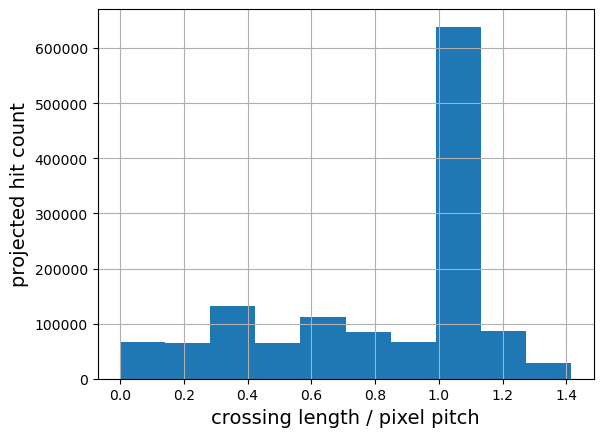

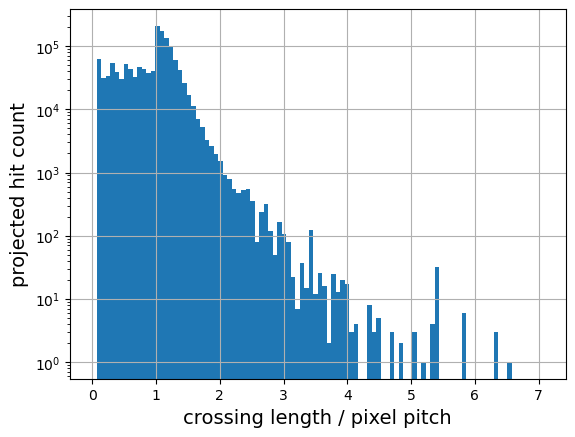

In [68]:
fig=plt.figure()
ax=fig.add_subplot()
ax.hist(f_nom['pixel_length'][:]/pixel_pitch, bins=10, range=(0,np.sqrt(2)));
ax.set_xlabel('crossing length / pixel pitch', fontsize=14)
ax.set_ylabel('projected hit count', fontsize=14)
ax.grid()

fig=plt.figure()
ax=fig.add_subplot()
ax.hist( (f_nom['pixel_length'][:])/(np.sin(f_nom['angle'][:]))/pixel_pitch, bins=100, range=(0,5*np.sqrt(2)));
ax.set_yscale('log')
#ax.axvline(1, color='red')
ax.set_xlabel('crossing length / pixel pitch', fontsize=14)
ax.set_ylabel('projected hit count', fontsize=14)
ax.grid()

In [19]:
# rough estimate of dQ/dx for a MIP
cm_to_ke = 1.8 / (23.6e-6) * 0.51 * 1e-3 # MeV/cm / MeV/e- * 0.45 (approx recombination)

In [50]:
pix_y_bins = np.concatenate( (pix_y, np.array( [np.max(pix_y) + pixel_pitch] )) )-pixel_pitch/2
pix_z_bins = np.concatenate( (pix_z, np.array( [np.max(pix_z) + pixel_pitch] )) )-pixel_pitch/2

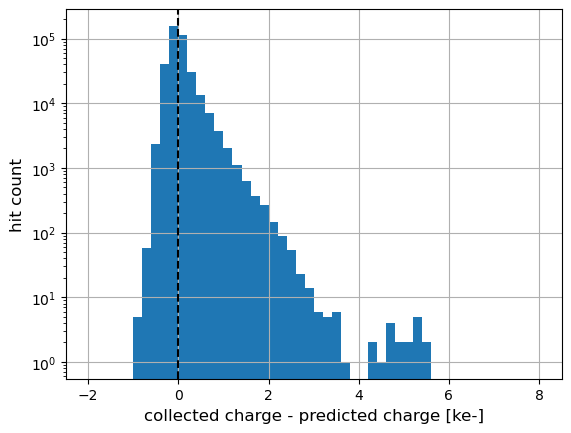

In [20]:
fig=plt.figure()
ax=fig.add_subplot()
charge_collected = np.array(f_nom['total_charge_collected'])
mask = (charge_collected > 0.0) & ( np.array(f_nom['pixel_length'][:])>pixel_pitch)
charge_pred = (np.array(f_nom['pixel_length']) / np.sin(np.array(f_nom['angle'])))*cm_to_ke
ax.hist( ((charge_collected -  charge_pred)/charge_pred)[mask], bins=50, range=(-2, 8) );
ax.axvline(0, color='black', linestyle='--')
ax.grid()
ax.set_xlabel('collected charge - predicted charge [ke-]', fontsize=12)
ax.set_ylabel('hit count', fontsize=12)
ax.set_yscale('log')

/tmp/ipykernel_1705461/568375384.py:8: RuntimeWarning: divide by zero encountered in log
  im=ax.imshow(np.log(vals).transpose(), origin='lower', extent=(5, 35, -2, 3))


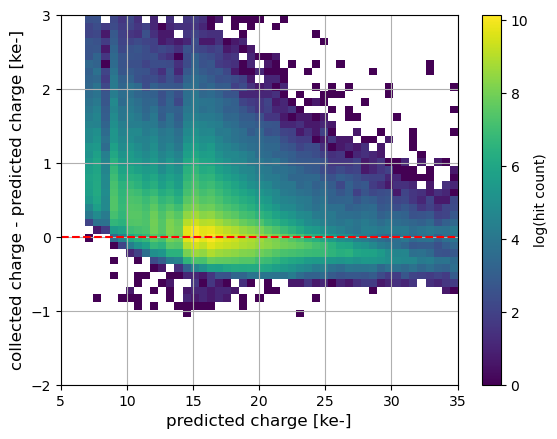

In [21]:

fig=plt.figure()
ax=fig.add_subplot()
charge_collected = np.array(f_nom['total_charge_collected'][:])
mask = (charge_collected > 0.0) & ( np.array(f_nom['pixel_length'][:])>pixel_pitch/2)
charge_pred = (np.array(f_nom['pixel_length'][:]) / np.sin(np.array(f_nom['angle'][:])))*cm_to_ke

vals, bins = np.histogramdd( np.array([charge_pred[mask], ((charge_collected -  charge_pred)/charge_pred)[mask]]).transpose(), bins=(np.linspace(5, 35, 50), np.linspace(-2, 3, 50)  ))
im=ax.imshow(np.log(vals).transpose(), origin='lower', extent=(5, 35, -2, 3))
cbar=plt.colorbar(im, ax=ax)
cbar.set_label('log(hit count)')
ax.axhline(0, color='red', linestyle='--')
ax.grid()
ax.set_xlabel('predicted charge [ke-]', fontsize=12)
ax.set_ylabel('collected charge - predicted charge [ke-]', fontsize=12)
ax.set_xlim(5, 35)
ax.set_aspect('auto')

In [22]:
!pip install pylandau
import pylandau
from scipy.optimize import curve_fit

Defaulting to user installation because normal site-packages is not writeable


In [28]:

def langau(x, a, b, c, d):
    # x, mpv, eta, sigma, A
    return pylandau.langau(x, a, b, c, d)

/tmp/ipykernel_1705461/3382246852.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return pylandau.langau(x, a, b, c, d)


MIP MPV ~ 38.62 +/- 0.07


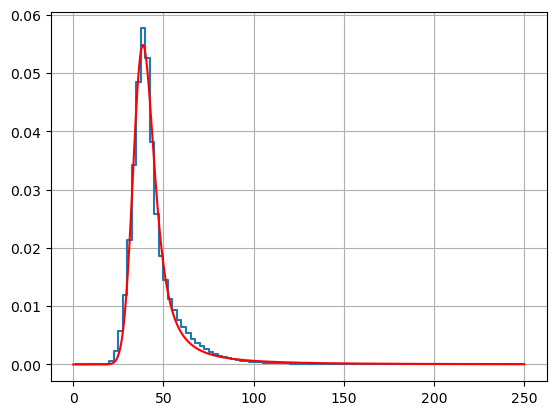

In [43]:
fig=plt.figure()
ax=fig.add_subplot()
charge_collected = np.array(f_nom['total_charge_collected'])
mask = (charge_collected > 0.0) & (np.array(f_nom['pixel_length'])>pixel_pitch/2) & (charge_collected > 0.0) & ( np.sin(np.array(f_nom['angle'])) > np.sqrt(2)/2)
distance = (np.array(f_nom['pixel_length']) / np.sin(np.array(f_nom['angle'])))
vals, bins = np.histogram( (charge_collected / distance)[mask], bins=100, range=(0, 250), density=True );
xx=(bins[:-1]+bins[1:])/2
params, pcov = curve_fit(langau, xx, vals, p0=[40, 10, 5, 5], bounds=(0,100) )

xxp = np.linspace(np.min(bins), np.max(bins), 500)

ax.plot(xx, vals, drawstyle='steps-mid')
ax.plot(xxp, langau(xxp, *params), color='red', label='langau fit')
ax.grid()

print('MIP MPV ~ {:0.2f} +/- {:0.2f}'.format(params[0], np.sqrt(pcov[0][0])))

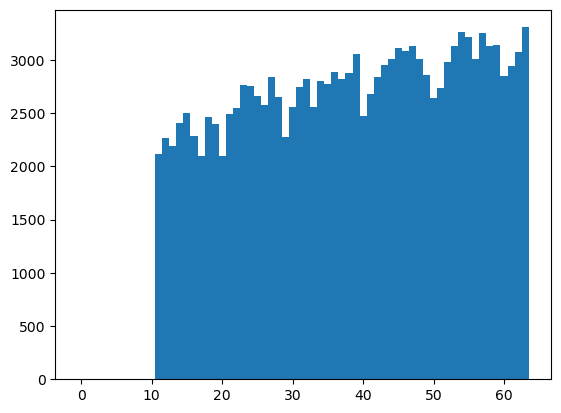

In [47]:
fig=plt.figure()
ax=fig.add_subplot()

m = (f_nom['is_hit'][:].astype(bool)) & (f_nom['anode'][:].astype(int)==2)
ax.hist( f_nom['hit_chan_id'][m].astype(int), bins=64, range=(-0.5,63.5) );

Text(0, 0.5, 'hit count')

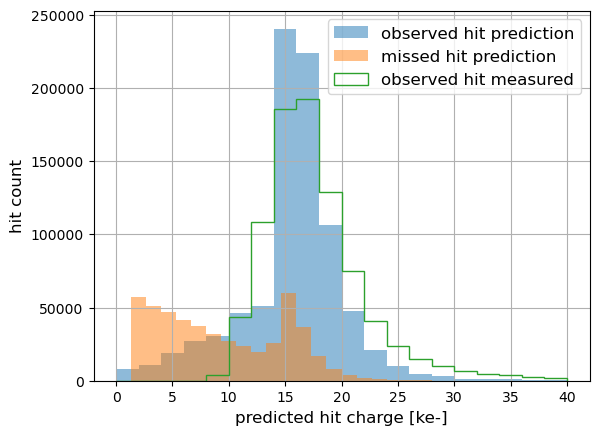

In [48]:
fig=plt.figure()
ax=fig.add_subplot()

pl = np.array(f_nom['pixel_length'][:])
hit = np.array(f_nom['is_hit'][:]).astype(bool)
angle = np.array(f_nom['angle'][:])
charge = np.array(f_nom['total_charge_collected'][:])

ax.hist( pl[hit]/np.sin(angle[hit])*cm_to_ke, bins=20, alpha=0.5, range=(0, 40), label='observed hit prediction');
ax.hist( pl[~hit]/np.sin(angle[~hit])*cm_to_ke, bins=30, alpha=0.5, range=(0,40), label='missed hit prediction');
ax.hist( charge[hit] , bins=20, range=(0,40), histtype='step', label='observed hit measured');

ax.grid()
ax.legend(fontsize=12)

ax.set_xlabel('predicted hit charge [ke-]', fontsize=12)
ax.set_ylabel('hit count', fontsize=12)

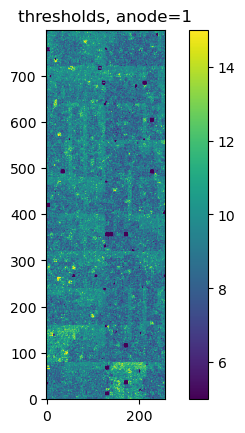

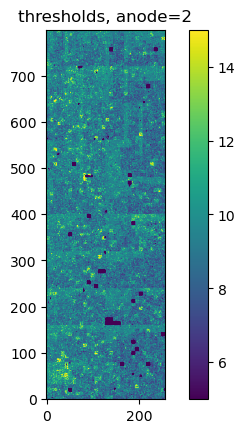

In [76]:
###
# Extract channel threshold information and geometry from FSD run
from collections import defaultdict
import yaml
import numpy as np

def _rotate_pixel(pixel_pos, tile_orientation):
    return pixel_pos[0]*tile_orientation[2], pixel_pos[1]*tile_orientation[1]


def get_geometry(geometry_yaml):
    def _default_pxy():
        return (0., 0.)

    with open(geometry_yaml) as fi:
        geo = yaml.full_load(fi)

    if 'multitile_layout_version' in geo.keys():
        # Adapted from: https://github.com/larpix/larpix-v2-testing-scripts/blob/master/event-display/evd_lib.py

        pixel_pitch = geo['pixel_pitch']

        chip_channel_to_position = geo['chip_channel_to_position']
        tile_orientations = geo['tile_orientations']
        tile_positions = geo['tile_positions']
        tile_indeces = geo['tile_indeces']
        xs = np.array(list(chip_channel_to_position.values()))[
            :, 0] * pixel_pitch
        ys = np.array(list(chip_channel_to_position.values()))[
            :, 1] * pixel_pitch
        x_size = max(xs)-min(xs)+pixel_pitch
        y_size = max(ys)-min(ys)+pixel_pitch

        tile_geometry = defaultdict(int)
        io_group_io_channel_to_tile = {}
        geometry = defaultdict(_default_pxy)

        for tile in geo['tile_chip_to_io']:
            tile_orientation = tile_orientations[tile]
            tile_geometry[tile] = tile_positions[tile], tile_orientations[tile]
            for chip in geo['tile_chip_to_io'][tile]:
                io_group_io_channel = geo['tile_chip_to_io'][tile][chip]
                io_group = io_group_io_channel//1000
                io_channel = io_group_io_channel % 1000
                io_group_io_channel_to_tile[(
                    io_group, io_channel)] = tile

            for chip_channel in geo['chip_channel_to_position']:
                chip = chip_channel // 1000
                channel = chip_channel % 1000
                try:
                    io_group_io_channel = geo['tile_chip_to_io'][tile][chip]
                except KeyError:
                    print("Chip %i on tile %i not present in network" %
                          (chip, tile))
                    continue

                io_group = io_group_io_channel // 1000
                io_channel = io_group_io_channel % 1000
                x = chip_channel_to_position[chip_channel][0] * \
                    pixel_pitch + pixel_pitch / 2 - x_size / 2
                y = chip_channel_to_position[chip_channel][1] * \
                    pixel_pitch + pixel_pitch / 2 - y_size / 2

                x, y = _rotate_pixel((x, y), tile_orientation)
                x += tile_positions[tile][2]
                y += tile_positions[tile][1]

                geometry[(io_group, io_group_io_channel_to_tile[(
                    io_group, io_channel)], chip, channel)] = x, y

        return geometry

geo=get_geometry('/pscratch/sd/s/sgberg/fsd_geo/multi_tile_layout-3.0.40_fsd_v3.yaml')

with open('dd_leakage.npy', 'rb') as f:
    dd_leakage=np.load(f)

with open('dd_peds.npy', 'rb') as f:
    dd_peds=np.load(f)

with open('dd_peds_rms.npy', 'rb') as f:
    dd_peds_rms=np.load(f)

with open('dd_un.npy', 'rb') as f:
    dd_un=np.load(f)
    
# convert unique to (y,z) position
dd_y = np.zeros( dd_un.shape[0] )
dd_z = np.zeros( dd_un.shape[0] )
dd_anode = np.zeros( dd_un.shape[0] )
for iun, un in enumerate(dd_un):
    io_group = unique_to_io_group(un)
    io_channel = unique_to_io_channel(un)
    chip_id = unique_to_chip_id(un)
    channel_id = unique_to_channel_id(un)

    y,z = geo[(io_group, ((io_channel - 1)//4+1) + 10 * (io_group - 1), chip_id, channel_id)]
    dd_y[iun] = z/10
    dd_z[iun] = y/10

    dd_anode[iun] = (io_group+1)//2

thr=(dd_leakage-dd_peds)
#convert thresholds to ke-
lsb = (1800*((223 / 256) - (68 / 256))/256)/4.5
thr_ke = thr * lsb

anode_thresholds = {}

for anode in [1,2]:
    m = (dd_anode==anode) & (thr>0) & (thr<20)
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('thresholds, anode={}'.format(anode))
    thresholds, bins = np.histogramdd( np.array([ dd_y[m], dd_z[m] ]).transpose(), bins=( pix_y_bins, pix_z_bins ), weights=thr[m]  )
    im = ax.imshow(thresholds, origin='lower', norm='linear', vmin=5, vmax=15)
    plt.colorbar(im, ax=ax)
    anode_thresholds[anode]=thresholds
###

In [77]:
mp = ((np.array(f_nom['pixel_length'][:]) ) > 0.200)&\
                (~(((np.array(f_nom['hit_io_chan']).astype(int)%4)==3) & (((np.array(f_nom['hit_chip_id']).astype(int))>140))) | (np.array(f_nom['hit_io_chan']).astype(int) < 0) )&\
                ( np.array(f_nom['pixel_z'][:]) > np.min(pix_z) + 20*pixel_pitch ) & ( np.array(f_nom['pixel_z'][:]) < np.max(pix_z) - 20*pixel_pitch )&\
                ( np.array(f_nom['pixel_y'][:]) > np.min(pix_y) + 20*pixel_pitch ) & ( np.array(f_nom['pixel_y'][:]) < np.max(pix_y) - 20*pixel_pitch )
#((np.array(f_nom['pixel_length']) / np.sin(np.array( f_nom['angle'] )) ) > pixel_pitch)&\
pl = np.array(f_nom['pixel_length'][:])
hit = np.array(f_nom['is_hit'][:]).astype(bool)
angle = np.array(f_nom['angle'][:])
charge = np.array(f_nom['total_charge_collected'][:])
anode = np.array(f_nom['anode'][:])
py = np.array(f_nom['pixel_y'][:])
pz = np.array(f_nom['pixel_z'][:])

#observed, bins = np.histogram( pl[hit]/np.sin(angle[hit])*cm_to_ke, bins=40, range=(0, 50));
#missed, bins = np.histogram( pl[~hit]/np.sin(angle[~hit])*cm_to_ke, bins=40, range=(0, 50));
#ax.hist( charge[hit] , bins=30, range=(0,40), histtype='step', label='observed hit measured');

#3d histogram data in y, z, q to find disabled channels and exclude them

#start with just anode 1

mask = (anode==1 & mp)

goodhits = np.array([py[mask & hit], pz[mask & hit], cm_to_ke*(np.array(pl)/np.sin(np.array(angle)))[mask & hit]]).transpose()

allhits = np.array([py[mask], pz[mask], cm_to_ke*(np.array(pl)/np.sin(np.array(angle)))[mask]]).transpose()


charge_bins = np.linspace(0, 50,40)
vals, bins = np.histogramdd( allhits, bins=(pix_y_bins, pix_z_bins, charge_bins) )

vals_hit, bins = np.histogramdd( goodhits , bins=(pix_y_bins, pix_z_bins, charge_bins))

disabled_mask = (~(np.sum( vals_hit, axis=2 )==0))


In [78]:
disabled_mask_and_threshold = (~(np.sum( vals_hit, axis=2 )==0)) & (( anode_thresholds[1] < 10.0))

/tmp/ipykernel_1705461/664663235.py:8: RuntimeWarning: invalid value encountered in divide
  ax.plot( xaxis[0], (np.sum(vals_hit[disabled_mask], axis=0)/np.sum(vals[disabled_mask], axis=0))[0], linestyle='--', marker='.', color='green', label='efficiency')
/tmp/ipykernel_1705461/664663235.py:18: RuntimeWarning: invalid value encountered in divide
  ax2.plot( xaxis, np.sum(vals_hit[disabled_mask], axis=0)/np.sum(vals[disabled_mask], axis=0), linestyle='--', marker='.', color='green')


Text(0, 0.5, 'hit count / 1e6')

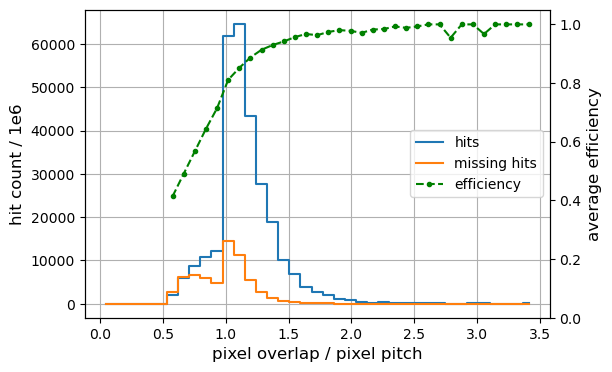

In [79]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot()
xaxis=((bins[2][:-1] + bins[2][1:])/2)/cm_to_ke/pixel_pitch
#vals=vals/1e12
#vals_hit=vals_hit/1e12
ax.plot( xaxis, np.sum(vals_hit[disabled_mask], axis=0), drawstyle='steps-mid', label='hits')
ax.plot( xaxis, np.sum(vals[disabled_mask], axis=0)-np.sum(vals_hit[disabled_mask], axis=0), drawstyle='steps-mid', label='missing hits')
ax.plot( xaxis[0], (np.sum(vals_hit[disabled_mask], axis=0)/np.sum(vals[disabled_mask], axis=0))[0], linestyle='--', marker='.', color='green', label='efficiency')
#ax.plot( xaxis, np.sum(vals_hit[disabled_mask_and_threshold], axis=0), drawstyle='steps-mid', label='hits (thresh<10ke-)')
#ax.plot( xaxis, np.sum(vals[disabled_mask_and_threshold], axis=0)-np.sum(vals_hit[disabled_mask_and_threshold], axis=0), drawstyle='steps-mid', label='missing hits (thresh<10ke-)')
#ax.plot( xaxis[0], (np.sum(vals_hit[disabled_mask_and_threshold], axis=0)/np.sum(vals[disabled_mask_and_threshold], axis=0))[0], linestyle='--', marker='.', color='purple', label='efficiency (thresh<10ke-)')
ax.ticklabel_format(style='sci')
ax.legend(loc=5, fontsize=10)


ax2 = ax.twinx()
ax.grid()
ax2.plot( xaxis, np.sum(vals_hit[disabled_mask], axis=0)/np.sum(vals[disabled_mask], axis=0), linestyle='--', marker='.', color='green')
#ax2.plot( xaxis, np.sum(vals_hit[disabled_mask_and_threshold], axis=0)/np.sum(vals[disabled_mask_and_threshold], axis=0), linestyle='--', marker='.', color='purple')
ax2.set_ylim(0,1.05)
#ax2.set_yscale('log')
ax2.set_ylabel('average efficiency', fontsize=12)
#ax2.axhline(0.97, color='red', linestyle='--')

ax.set_xlabel('pixel overlap / pixel pitch', fontsize=12)
#ax.axvline(pixel_pitch, color='grey', linestyle='--')
ax.set_ylabel('hit count / 1e6', fontsize=12)


/tmp/ipykernel_1705461/1600195705.py:39: RuntimeWarning: invalid value encountered in divide
  im = ax.imshow(hvals/pvals,vmin=0.1, vmax=1, origin='lower' )
/tmp/ipykernel_1705461/1600195705.py:41: RuntimeWarning: invalid value encountered in divide
  anode_efficiency[anode] = hvals/pvals
/tmp/ipykernel_1705461/1600195705.py:42: RuntimeWarning: invalid value encountered in divide
  pdf, bins = np.histogram((hvals/pvals).flatten(), bins=n_cdf_bins, range=(1e-1,1.01), density=True)


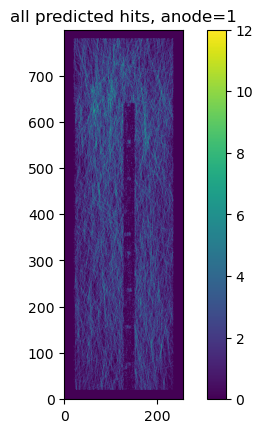

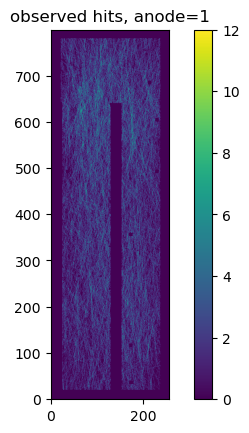

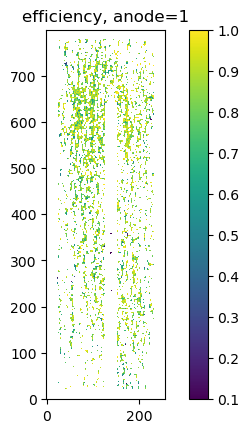

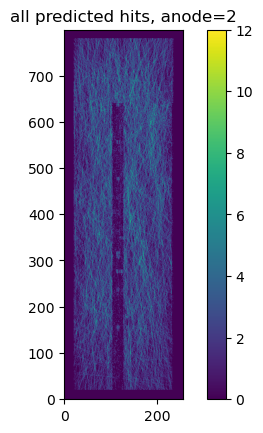

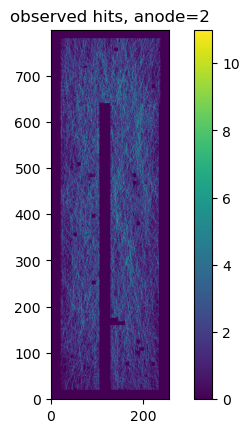

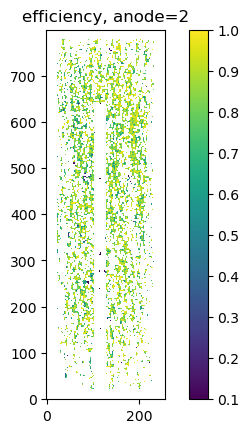

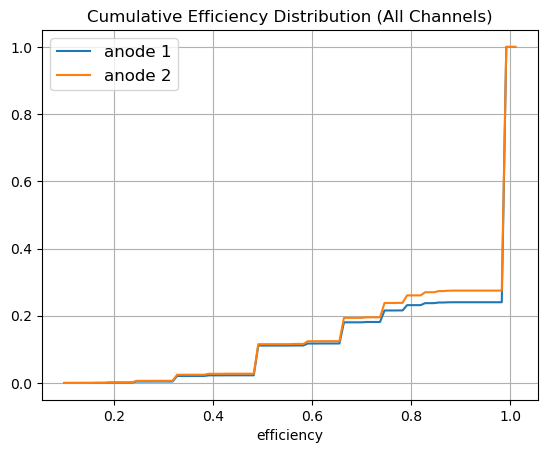

In [81]:
anode_efficiency={}
cdfs=[]
n_cdf_bins=100

disabled_masks=[]
py, pz = np.array(f_nom['pixel_y']), np.array( f_nom['pixel_z'])
#hy, hz = np.array(f_nom['pixel_y'][~(f_nom['is_hit'][:].astype(bool))]), np.array( f_nom['pixel_z'][~(f_nom['is_hit'][:].astype(bool))])
for anode in [1, 2]:
    mp = (np.array(f_nom['anode']) == anode) &\
             ((np.array(f_nom['pixel_length']) ) > 0.200)&\
             ((np.array(f_nom['pixel_length'])/np.sin(np.array(f_nom['angle'])) ) >= pixel_pitch)&\
             (~(((np.array(f_nom['hit_io_chan']).astype(int)%4)==3) & (((np.array(f_nom['hit_chip_id']).astype(int))>140))) | (np.array(f_nom['hit_io_chan']).astype(int) < 0) )&\
             ( np.array(f_nom['pixel_z'][:]) > np.min(pix_z) + 20*pixel_pitch ) & ( np.array(f_nom['pixel_z'][:]) < np.max(pix_z) - 20*pixel_pitch )&\
             ( np.array(f_nom['pixel_y'][:]) > np.min(pix_y) + 20*pixel_pitch ) & ( np.array(f_nom['pixel_y'][:]) < np.max(pix_y) - 20*pixel_pitch )

    mh = mp & ( (f_nom['is_hit'][:].astype(bool)))
            
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('all predicted hits, anode={}'.format(anode))
    pvals, pbins = np.histogramdd( np.array([ py[mp], pz[mp] ]).transpose(), bins=( pix_y_bins, pix_z_bins ) )
    im = ax.imshow(pvals, origin='lower')
    plt.colorbar(im, ax=ax)
    
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('observed hits, anode={}'.format(anode))
    hvals, hbins = np.histogramdd( np.array([ py[mh], pz[mh] ]).transpose(), bins=( pix_y_bins, pix_z_bins ) )
    im = ax.imshow(hvals, origin='lower')
    plt.colorbar(im, ax=ax)

    #mm = pvals > 3

    #1-hvals/pvals
    
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('efficiency, anode={}'.format(anode))
    im = ax.imshow(hvals/pvals,vmin=0.1, vmax=1, origin='lower' )
    plt.colorbar(im, ax=ax)
    anode_efficiency[anode] = hvals/pvals
    pdf, bins = np.histogram((hvals/pvals).flatten(), bins=n_cdf_bins, range=(1e-1,1.01), density=True)
    cdfs.append(list(np.cumsum(pdf)/np.max(np.cumsum(pdf))) + [1.0])


fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Cumulative Efficiency Distribution (All Channels)')
ax.set_xlabel('efficiency')
ax.grid()
for ic, cdf in enumerate(cdfs):
    ax.plot(np.linspace(1e-1, 1.01, n_cdf_bins+1), cdf, label='anode {}'.format(ic+1))
    #ax.set_yscale('log')


ax.legend(fontsize=12)


    

anode


/tmp/ipykernel_1705461/2780063300.py:45: RuntimeWarning: invalid value encountered in divide
  im = ax.imshow(hvals/pvals,vmin=0.1, vmax=1, origin='lower' )
/tmp/ipykernel_1705461/2780063300.py:47: RuntimeWarning: invalid value encountered in divide
  anode_efficiency[anode] = hvals/pvals
/tmp/ipykernel_1705461/2780063300.py:48: RuntimeWarning: invalid value encountered in divide
  pdf, bins = np.histogram((hvals/pvals).flatten(), bins=n_cdf_bins, range=(1e-1,1.01), density=True)


anode


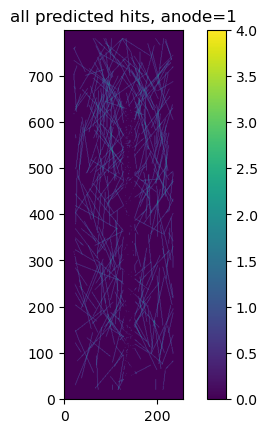

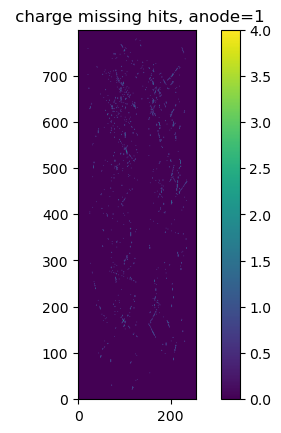

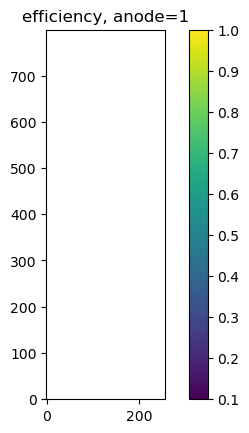

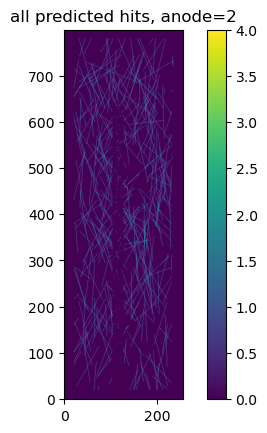

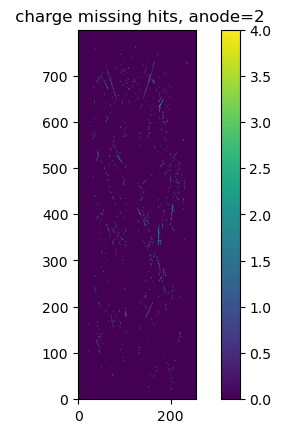

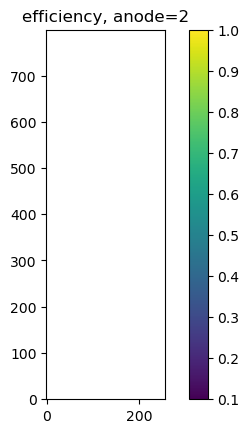

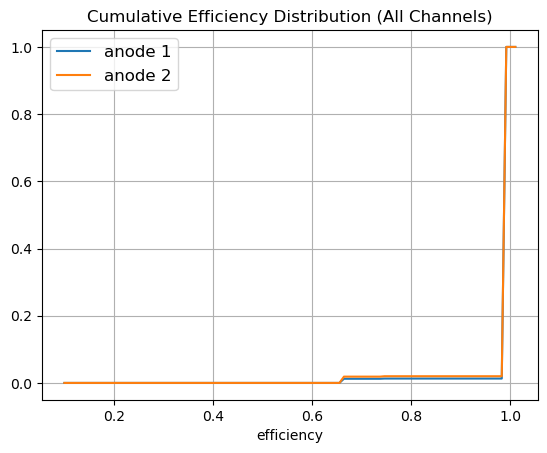

In [54]:
anode_efficiency={}
cdfs=[]
n_cdf_bins=100
py, pz = np.array(f_nom['pixel_y']), np.array( f_nom['pixel_z'])
#hy, hz = np.array(f_nom['pixel_y'][~(f_nom['is_hit'][:].astype(bool))]), np.array( f_nom['pixel_z'][~(f_nom['is_hit'][:].astype(bool))])
for anode in [1, 2]:
    print('anode')
    mp = (np.array(f_nom['anode']) == anode) &\
                 ((np.array(f_nom['pixel_length']) ) > 0.200)&\
                (np.sin((np.array(f_nom['angle'])) ) < np.sqrt(2)/2)&\
                (~(((np.array(f_nom['hit_io_chan']).astype(int)%4)==3) & (((np.array(f_nom['hit_chip_id']).astype(int))>140))) | (np.array(f_nom['hit_io_chan']).astype(int) < 0) )&\
                ( np.array(f_nom['pixel_z'][:]) > np.min(pix_z) + 20*pixel_pitch ) & ( np.array(f_nom['pixel_z'][:]) < np.max(pix_z) - 20*pixel_pitch )&\
                ( np.array(f_nom['pixel_y'][:]) > np.min(pix_y) + 20*pixel_pitch ) & ( np.array(f_nom['pixel_y'][:]) < np.max(pix_y) - 20*pixel_pitch )
             #((np.array(f_nom['pixel_length'])/np.sin(np.array(f_nom['angle']))*cm_to_ke) >= 12.)
    
            #(~(((np.array(f_nom['hit_io_chan']).astype(int)%4)==3)) | (np.array(f_nom['hit_io_chan']).astype(int) < 0) )

    mh = mp & ( (f_nom['is_hit'][:].astype(bool)))
    observed_hits = mp & (f_nom['is_hit'][:].astype(bool))
            
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('all predicted hits, anode={}'.format(anode))
    pvals, pbins = np.histogramdd( np.array([ py[mp], pz[mp] ]).transpose(), bins=( pix_y_bins, pix_z_bins ) )
    im = ax.imshow(pvals, origin='lower')
    plt.colorbar(im, ax=ax)

    obs_vals, obs_bins = np.histogramdd( np.array([ py[observed_hits], pz[observed_hits] ]).transpose(), bins=( pix_y_bins, pix_z_bins ) )
    
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title(' charge missing hits, anode={}'.format(anode))
    hvals, hbins = np.histogramdd( np.array([ py[mh], pz[mh] ]).transpose(), bins=( pix_y_bins, pix_z_bins ) )
    hvals[obs_vals < 2] = 0
    im = ax.imshow(hvals, origin='lower')
    plt.colorbar(im, ax=ax)

    #mm = pvals > 3

    #1-hvals/pvals
    
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('efficiency, anode={}'.format(anode))
    im = ax.imshow(hvals/pvals,vmin=0.1, vmax=1, origin='lower' )
    plt.colorbar(im, ax=ax)
    anode_efficiency[anode] = hvals/pvals
    pdf, bins = np.histogram((hvals/pvals).flatten(), bins=n_cdf_bins, range=(1e-1,1.01), density=True)
    cdfs.append(list(np.cumsum(pdf)/np.max(np.cumsum(pdf))) + [1.0])

fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Cumulative Efficiency Distribution (All Channels)')
ax.set_xlabel('efficiency')
ax.grid()
for ic, cdf in enumerate(cdfs):
    ax.plot(np.linspace(1e-1, 1.01, n_cdf_bins+1), cdf, label='anode {}'.format(ic+1))
    #ax.set_yscale('log')


ax.legend(fontsize=12)

    

/tmp/ipykernel_1705461/3182218631.py:38: RuntimeWarning: invalid value encountered in divide
  im = ax.imshow(hvals/pvals,vmin=0.1, vmax=1, origin='lower' )
/tmp/ipykernel_1705461/3182218631.py:40: RuntimeWarning: invalid value encountered in divide
  anode_efficiency[anode] = hvals/pvals
/tmp/ipykernel_1705461/3182218631.py:41: RuntimeWarning: invalid value encountered in divide
  pdf, bins = np.histogram((hvals/pvals).flatten(), bins=n_cdf_bins, range=(1e-1,1.01), density=True)


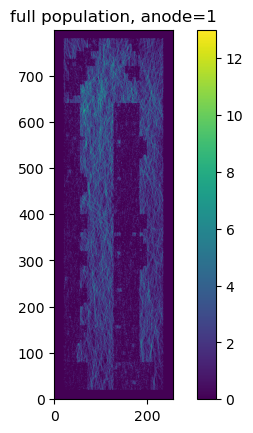

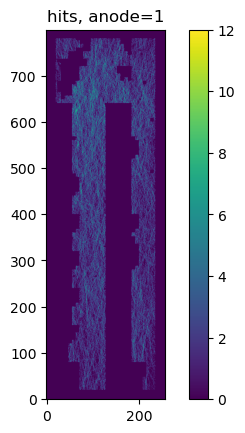

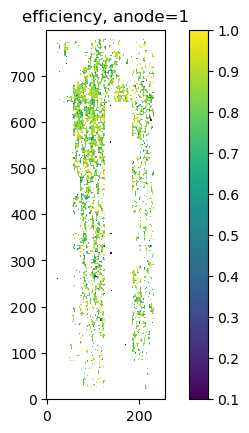

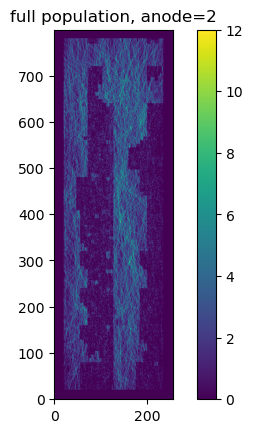

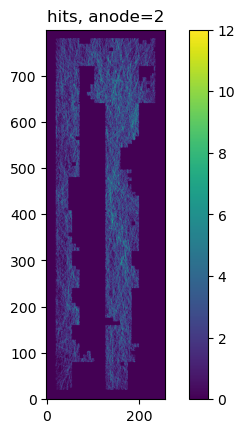

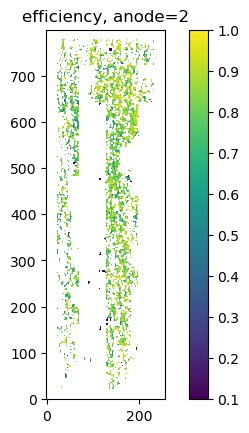

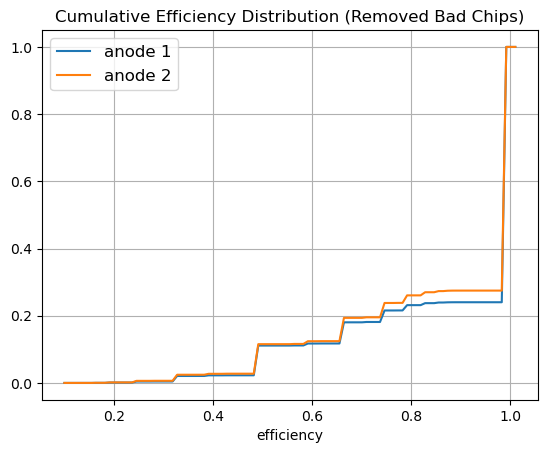

In [83]:
anode_efficiency={}
cdfs_no3=[]
n_cdf_bins=100
py, pz = np.array(f_nom['pixel_y']), np.array( f_nom['pixel_z'])
#hy, hz = np.array(f_nom['pixel_y'][~(f_nom['is_hit'][:].astype(bool))]), np.array( f_nom['pixel_z'][~(f_nom['is_hit'][:].astype(bool))])
for anode in [1, 2]:
    mp = (np.array(f_nom['anode']) == anode) &\
             ((np.array(f_nom['pixel_length']) ) > 0.200)&\
             ((np.array(f_nom['pixel_length'])/np.sin(np.array(f_nom['angle']))*cm_to_ke ) >= 12.)&\
            (~(((np.array(f_nom['hit_io_chan']).astype(int)%4)==3)) | (np.array(f_nom['hit_io_chan']).astype(int) < 0) )&\
            ( np.array(f_nom['pixel_z'][:]) > np.min(pix_z) + 20*pixel_pitch ) & ( np.array(f_nom['pixel_z'][:]) < np.max(pix_z) - 20*pixel_pitch )&\
            ( np.array(f_nom['pixel_y'][:]) > np.min(pix_y) + 20*pixel_pitch ) & ( np.array(f_nom['pixel_y'][:]) < np.max(pix_y) - 20*pixel_pitch )        
    #(~(((np.array(f_nom['hit_io_chan']).astype(int)%4)==3)) | (np.array(f_nom['hit_io_chan']).astype(int) < 0) )

    mh = mp & ( (f_nom['is_hit'][:].astype(bool)))
            
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('full population, anode={}'.format(anode))
    pvals, pbins = np.histogramdd( np.array([ py[mp], pz[mp] ]).transpose(), bins=( pix_y_bins, pix_z_bins ) )
    im = ax.imshow(pvals, origin='lower')
    plt.colorbar(im, ax=ax)
    
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('hits, anode={}'.format(anode))
    hvals, hbins = np.histogramdd( np.array([ py[mh], pz[mh] ]).transpose(), bins=( pix_y_bins, pix_z_bins ) )
    im = ax.imshow(hvals, origin='lower')
    plt.colorbar(im, ax=ax)

    #mm = pvals > 3

    #1-hvals/pvals
    
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title('efficiency, anode={}'.format(anode))
    im = ax.imshow(hvals/pvals,vmin=0.1, vmax=1, origin='lower' )
    plt.colorbar(im, ax=ax)
    anode_efficiency[anode] = hvals/pvals
    pdf, bins = np.histogram((hvals/pvals).flatten(), bins=n_cdf_bins, range=(1e-1,1.01), density=True)
    cdfs_no3.append(list(np.cumsum(pdf)/np.max(np.cumsum(pdf))) + [1.0])

fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Cumulative Efficiency Distribution (Removed Bad Chips)')
ax.set_xlabel('efficiency')
ax.grid()
for ic, cdf in enumerate(cdfs):
    ax.plot(np.linspace(1e-1, 1.01, n_cdf_bins+1), cdf, label='anode {}'.format(ic+1))
    #ax.set_yscale('log')

ax.legend(fontsize=12)

    

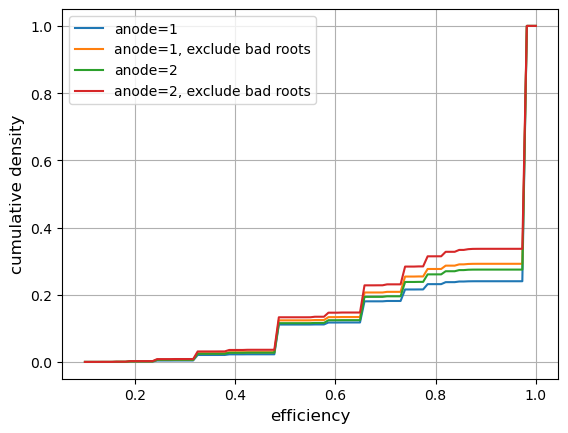

In [84]:
fig=plt.figure()

plx = np.linspace(1e-1, 1, len(cdfs[0]))

ax= fig.add_subplot()

ax.plot(plx, cdfs[0], label='anode=1')
ax.plot(plx, cdfs_no3[0], label='anode=1, exclude bad roots')

ax.plot(plx, cdfs[1], label='anode=2')
ax.plot(plx, cdfs_no3[1], label='anode=2, exclude bad roots')
ax.set_xlabel('efficiency', fontsize=12)
ax.set_ylabel('cumulative density', fontsize=12)

ax.grid()
ax.legend()

/tmp/ipykernel_1705461/3185814341.py:7: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(norms), origin='lower', extent=( (0,1,0,30) ))


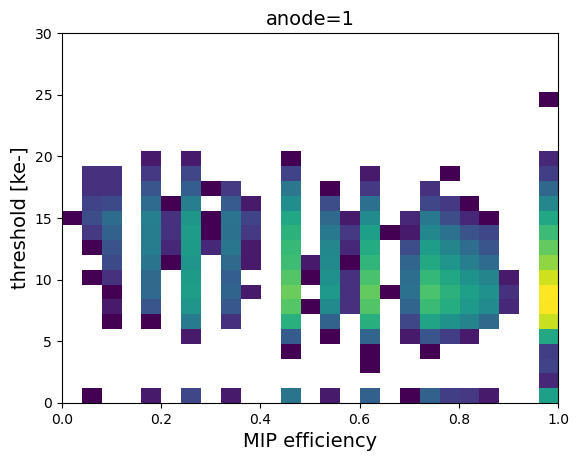

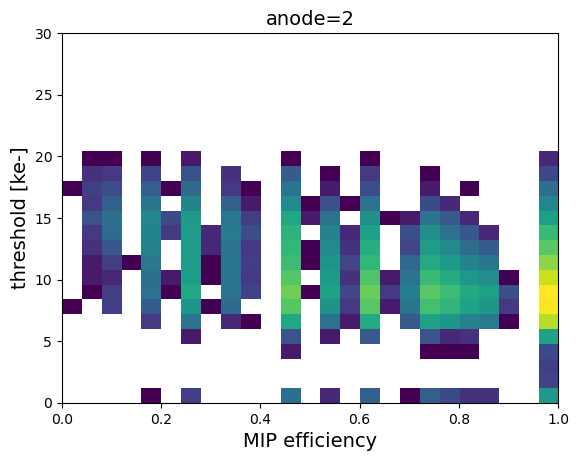

In [85]:
#make heat map of threshold vs. efficiency
for anode in [1,2]:
    fig = plt.figure()
    ax = fig.add_subplot()
    #get normalization
    norms, bins = np.histogramdd( np.array([anode_thresholds[anode].flatten(), anode_efficiency[anode].flatten()]).transpose(), bins=(25,25), range=( (0,30), (0.1,1) ))
    ax.imshow(np.log(norms), origin='lower', extent=( (0,1,0,30) ))
    ax.set_xlabel('MIP efficiency', fontsize=14)
    ax.set_ylabel('threshold [ke-]', fontsize=14)
    ax.set_aspect('auto')
    ax.set_title('anode={}'.format(anode), fontsize=14)
